## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. we will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Show workspace status

In [1]:
import nltk
import sklearn
from platform import python_version


print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The python version is {}.'.format(python_version()))

The nltk version is 3.2.5.
The scikit-learn version is 0.19.1.
The python version is 3.6.3.


----
## Exploring the Data
 Note: that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

#  Display the first 5 records
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [3]:
# Show all the columns of the data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [4]:
# View values of the `"income"`column
data.income.value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

###  Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below :
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.



In [5]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = data.income.value_counts()[1]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.income.value_counts()[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = ((data.income.value_counts()[1] / n_records)*100).round(2)
 
# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


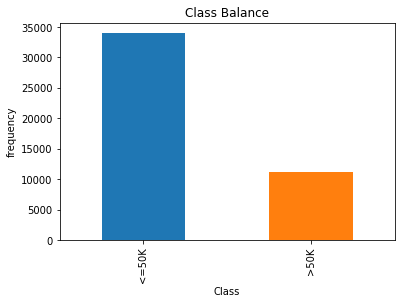

In [6]:
# Plot the class of the `"income"`column
data.income.value_counts().plot(kind= "bar")
plt.xlabel("Class")
plt.ylabel("frequency") 
plt.title("Class Balance");

** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

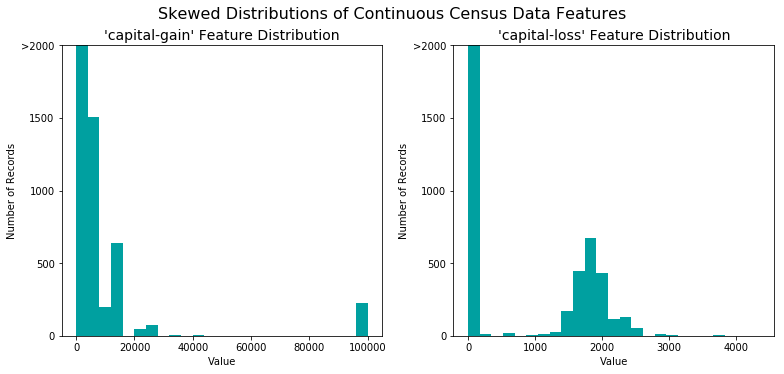

In [7]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

In [8]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.


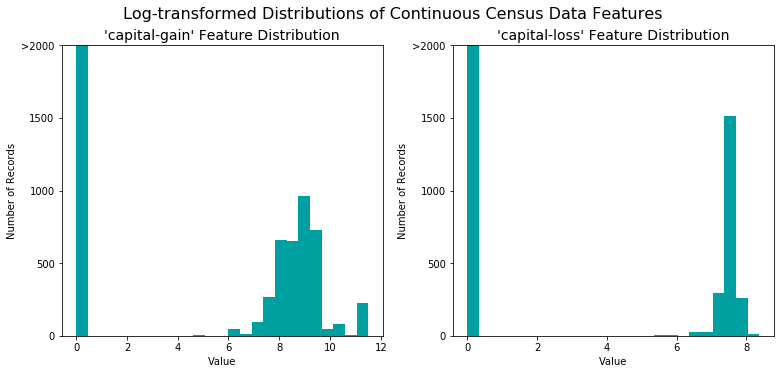

In [9]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

In [10]:
features_log_transformed[skewed].describe()

,capital-gain,capital-loss
count,45222.000000,45222.000000
mean,0.740759,0.355489
std,2.466527,1.595914
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,11.512925,8.379539


### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.



In [11]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

    |     someFeature |                               | someFeature_A | someFeature_B | someFeature_C |
    | :----: | :----: |                               | :-----------: |  :-----------:|  :----------: |
    |    0   |   B    |                               |     0         |       1       |        0      |
    |    1   |   C    |   ----> one-hot encode ---->  |     0         |       0       |        1      |
    |    2   |   A    |                               |     1         |       0       |        0      |
    
    
  

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:


In [12]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = (income_raw == ">50K").astype(int)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

In [13]:
# Check for leaky columns
features_log_minmax_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 13 columns):
age                45222 non-null float64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
dtypes: float64(5), object(8)
memory usage: 4.5+ MB


In [14]:
# Check categorical columns for low or high cardinality
features_log_minmax_transform.select_dtypes('object').nunique()

workclass           7
education_level    16
marital-status      7
occupation         14
relationship        6
race                5
sex                 2
native-country     41
dtype: int64

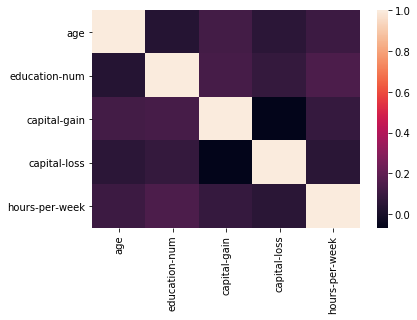

In [15]:
# Ckeck columns for multicollinearity
corr = features_log_minmax_transform.select_dtypes('number').corr()
sns.heatmap(corr)

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.


In [16]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (*those who make at most \$50,000* ,  and  those  who  make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *this person does not make more than \$50,000* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

###  Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

**HINT:** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

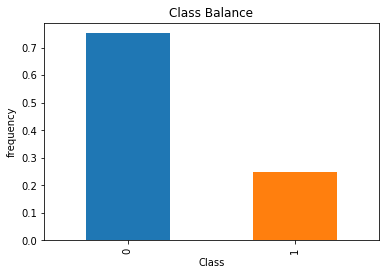

In [17]:
# Plot the balance of the target
income.value_counts(normalize=True).plot(kind= "bar")
plt.xlabel("Class")
plt.ylabel("frequency") 
plt.title("Class Balance");

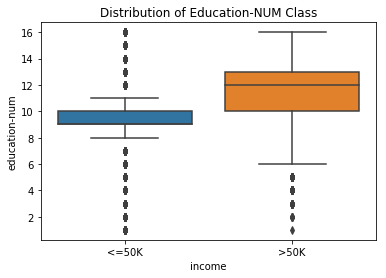

In [18]:
# Plot the Distribution of Education-NUM on the target
sns.boxplot(x = "income" , y ="education-num" , data = data  )
plt.title('Distribution of Education-NUM Class');

In [19]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.75


In [20]:
TP = np.sum(income) 
""" 
Counting the ones as this is the naive case. Note that 'income' is the 'income_raw'data encoded to numerical values done in
the data preprocessing step
""" 
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy =  (TP+TN) / (TP+FP+TN+FN)

recall = TP / (TP+FN)

precision = TP / (TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2) * ((precision * recall) / ((0.5**2 * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) :
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

###   Models Application
Here three of the supervised learning models above that are appropriate for this problem.

## 1. *Logistic Regression:*
*  **Application** :
    - it’s used for movie reviews, while in Medicine it can be used to calculate the probability of disease.
*     **Strength** : 
   - It can be regularized to avoid overfitting.
   - Speed is one of the advantages of logistic regression as it takes less time and computing power than other models
*  **Weakness** :
    - Logistic regression has weak performance when dealing with multiple or non-linear  boundaries
*  **suitability** :
   - Logistic regression is easier to build with high performance.
   
## 2. *Decision Trees:*
*  **Application** : 
    - it can be used for online stores for product recommendations.
    
*  **Strength** : 
    - it doesn't need much computation power.
    - can work easily with continuous and categorical variables.
    -  highlight the importance of different features to estimate the target.
    
*  **Weakness** :
   - It perfom poorly with small data sets 

*  **suitability** :
   - Decision trees can handle non-linear data sets.

   
## 3. *Gradient Boosting:*
*  **Application** :
    - It can be used for commercial web search engines and to estimate Construction Accidents.
*  **Strength** : 
    - Lots of flexibility 
    - it can handle data without data pre-processing.
    - Handles missing data without needing to  imputation 
*  **Weakness** :
    -  When dealing with a large amount of outliers Gradient Boosting model tends to overfit the data 
    - Computationally expensive and need high Comput power with large and complex  data 
  
*  **ٍSuitability** :
   - The Gradient Boosting model is a better learner and gives more accurate results.

## *References:*

- [Logistic Regression](https://towardsdatascience.com/logistic-regression-in-real-life-building-a-daily-productivity-classification-model-a0fc2c70584e#:~:text=Logistic%20regression%20is%20used%20across,patient%20developing%20a%20particular%20disease.)

- [Logistic Regression](https://elitedatascience.com/machine-learning-algorithms#:~:text=Strengths%3A%20Outputs%20have%20a%20nice,or%20non%2Dlinear%20decision%20boundaries.)
    
- [Logistic Regression](https://activewizards.com/blog/5-real-world-examples-of-logistic-regression-application)

- [Decision Trees](https://www.geeksforgeeks.org/decision-tree/?ref=leftbar-rightbar)

- [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting)

- [Gradient Boosting](https://www.hindawi.com/journals/ace/2019/1574297/)

- [Gradient Boosting](https://blog.paperspace.com/gradient-boosting-for-classification/)



###  Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, we will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - set the `beta` parameter

In [21]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score , accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    #  Calculate the training time
    results['train_time'] = end - start
        
    #  Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300] , predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test , predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300] , predictions_train ,  beta =.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test , predictions_test ,  beta =.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation
In the code cell, we will implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model .
  - **Note:**We will the default settings for each model — we will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.
  
**Note:** Depending on the algorithms we've chosen, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


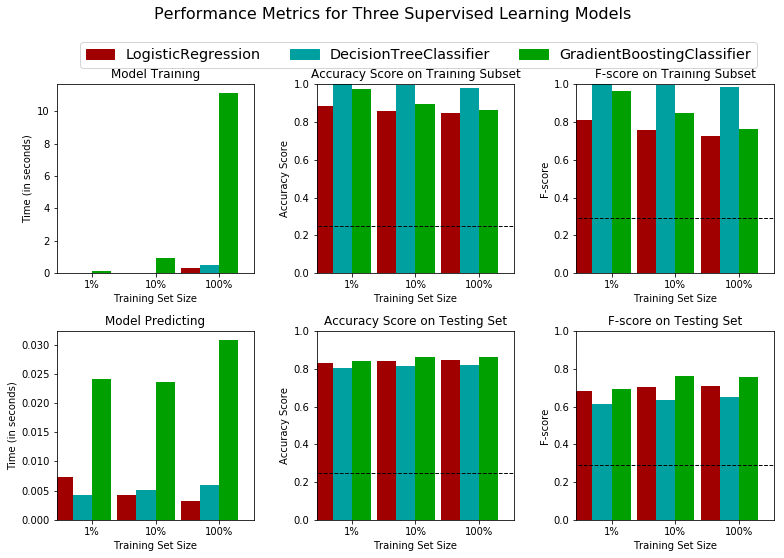

In [22]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  GradientBoostingClassifier

# Initialize the three models
clf_A = LogisticRegression(max_iter=1000,random_state=42)
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = GradientBoostingClassifier(random_state=42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100 *.1)
samples_1 = int(samples_100 *.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [99]:
for key,value in results.items():   
        display(key)
        display(pd.DataFrame(value))

'LogisticRegression'

,0,1,2
acc_test,0.831730,0.841680,0.845329
acc_train,0.886667,0.856667,0.846667
f_test,0.680867,0.704378,0.709896
f_train,0.812325,0.756677,0.728291
pred_time,0.007377,0.004309,0.003210
train_time,0.005882,0.022264,0.328417


'DecisionTreeClassifier'

,0,1,2
acc_test,0.803980,0.814262,0.820896
acc_train,1.000000,0.996667,0.980000
f_test,0.614437,0.635077,0.648230
f_train,1.000000,0.997506,0.984252
pred_time,0.004266,0.005040,0.005899
train_time,0.003206,0.032470,0.535678


'GradientBoostingClassifier'

,0,1,2
acc_test,0.839248,0.863239,0.863792
acc_train,0.973333,0.896667,0.863333
f_test,0.693434,0.761771,0.757984
f_train,0.964010,0.851064,0.764873
pred_time,0.024091,0.023574,0.030821
train_time,0.106360,0.923608,11.092637


----
## Improving Results
In this  section, we will choose from the three supervised learning models the *best* model to use on the data. we will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning  parameters to improve upon the untuned model's F-score. 

###  Choosing the Best Model 

- According to the graph and its status we will choose the GradientBoostingClassifier as it has the highest accuracy 0.86,  best $F_{\beta}score$ 0.75  on the test set with the  100% sample.

- Although the training time for GradientBoostingClassifier was higher than other Classifiers, it is a better learner and generalizes better on the data set, but here if we care more about time and Computational power LogisticRegression will be our knight in shining armor.

- In the end, both  LogisticRegression and GradientBoostingClassifier suit our data, but we are choosing GradientBoostingClassifier based on its performance.

#  Describing the Model 



- Simply, Gradient boosting classifiers use some technics not only to make weak models in their way to build a strong model to fit the data but also to build an intuition to set the next model after every model is set based on minimizing the error (  maximizing the result ) to get to the best model fit the data and give high scores.



- To explain this we need to break it into small pieces ,so relax and enjoy the ride.

## Machine learning

- Machine learning is about trial and error processing and analyzing the rate of change. 

- let's say we have a problem and we try to get the most suitable solve for it.

- like in basketball , we try to throw a ball into the basket **(the target )** and the goal is to get the ball inside the basket so we get the points.

- We have 2 possible outcomes here either the ball goes in or not  **( yes, or no )**.

- The ball here represents our data, for example, small, medium, and large balls here we can call the type of ball our **labeled data.**

- According to the data we have here, we want to estimate whether the person is a donor or not **( the target )** and the personal attributes are our **labeled data.**

- From here we can say we need to use **a Supervised machine learning model.**


## Supervised machine learning models:

- Supervised machine learning algorithms work with **labeled data** (deja vu).
- But Supervised machine learning  models have 2 types which one to use ?, to answer this question we need to know about the 2 types of models :

    *    1- **Regression models**:
    those models help us to estimate numeric values such as house price.

    *    2- **Classification models**: 
    those models help us to estimate a categorical value, In some cases used for events with only two possible outcomes, such as either the ball goes in or out,this person can be a potential donor or not, stocks market price goes up or down,  **( yes, or no )**. sound familiar 


- So far so good we know that we need to use supervised machine learning models, but which algorithm to choose there are too many out there.

## Decision Trees:

- let's imagine that a decision tree is a path with all solutions we need to make a decision based on different conditions to help you to imagine it look at the graph below this cell , it builds on asking questions to our  data to reach the most suitable solution


- For example, when you call a custom service for a company, the voice system keeps asking you questions and you answer by pressing the number that suits your case until you reach the right agent to help you or get the service you want, they also build a profile about you to hence the services they give to you but it another story to tell later.

- But a Decision Tree is an **individual** approach to estimating the target 
it tends to over fit which means that they are great on training and give high results on training data but poorly on the test data, for example, look at the graph above when we use 3 different models to train and test our data, the blue line which represents the  Decision Tree model almost get 100% score that means very good but on training data when it comes to the test data its result drop significantly and that called overfitting 

- That is why the Decision Tree is called a **(weak leaner ).**
Thanks to Allah, data scientists came up with Ensemble Learning.


## Ensemble Learning :

- The whole idea here is that we can combine the many models (weak learners) such as Decision Tree as the combination of these models is better at predicting than the individual models and we called them  **(strong learners).** 

- Think about it like this: 2 humans think about a problem is better than one, 3 is better than 2, and so on.

- There are 2 types of Ensemble models : 

-    1- bagging :

    - Here we train **weak learn** on random parts of the data and then take the average of these models to make our strong model for example: solving a test, we call our friends to answer the questions then we take the average answer on every question by the answer which gets the most votes.

*    2- boosting:

    - Here we train a model then another model which focuses on the mistakes of the previous model and tries to get better accuracy on the parts which the first model performance poorly estimating it, then a third model which tries to cover the error on the combination of the previous models and so on until we get to the ideal solve.

    - it is like the idea of learning from our mistakes to evolve 

- **But why boosting ?**  
    - what is better to learn from random parts of your life or learn from  your mistakes?

    - in my opinion, learning from mistakes is better than why boosting models are winning out there in data science competitions.

- **we can find the application of boosting in Gradient Boosting.**

## Gradient Boosting :

- The idea here is to calculate outcomes for this next model to minimize the error(fix the mistake ). 

- Gradient boosting builds a combination of models one by one, then the results of all models are combined.

    - combination  = input model 1 + input model 2 + input model 3 

- The next model hence  the current models and minimize the training error of the ensemble to get to our main target .

- In the ideal slove  we want to get 

    - current combination + input model 4 = main traget 

- To get closer to the main target  we train model 4 to identify the difference between the main target  and the current combination, which is called the residual (inputs of the next model ) 

    - residual =  main traget - current combination

- This is the main idea but in practice, we can't get a model with 0 errors that estimate the main target 100%.


- we can see here that Gradient Boosting is based on reducing the error and that is how it gets its name The Gradient Boosting classifier.


 **Fascinating, how just machines can do all of this, how humans develop things that work on electrical impulses (volt on volt off (1 0) )  to do our most complex tasks, and how Allah inspires us to do all of this.**


#### References:

- [Link 1](https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/)
- [Link 2](https://www.displayr.com/gradient-boosting-the-coolest-kid-on-the-machine-learning-block/)
- [Link 3](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
- [Link 4](https://www.displayr.com/gradient-boosting-the-coolest-kid-on-the-machine-learning-block/)
- [Link 4](https://www.machinelearningplus.com/machine-learning/an-introduction-to-gradient-boosting-decision-trees/)



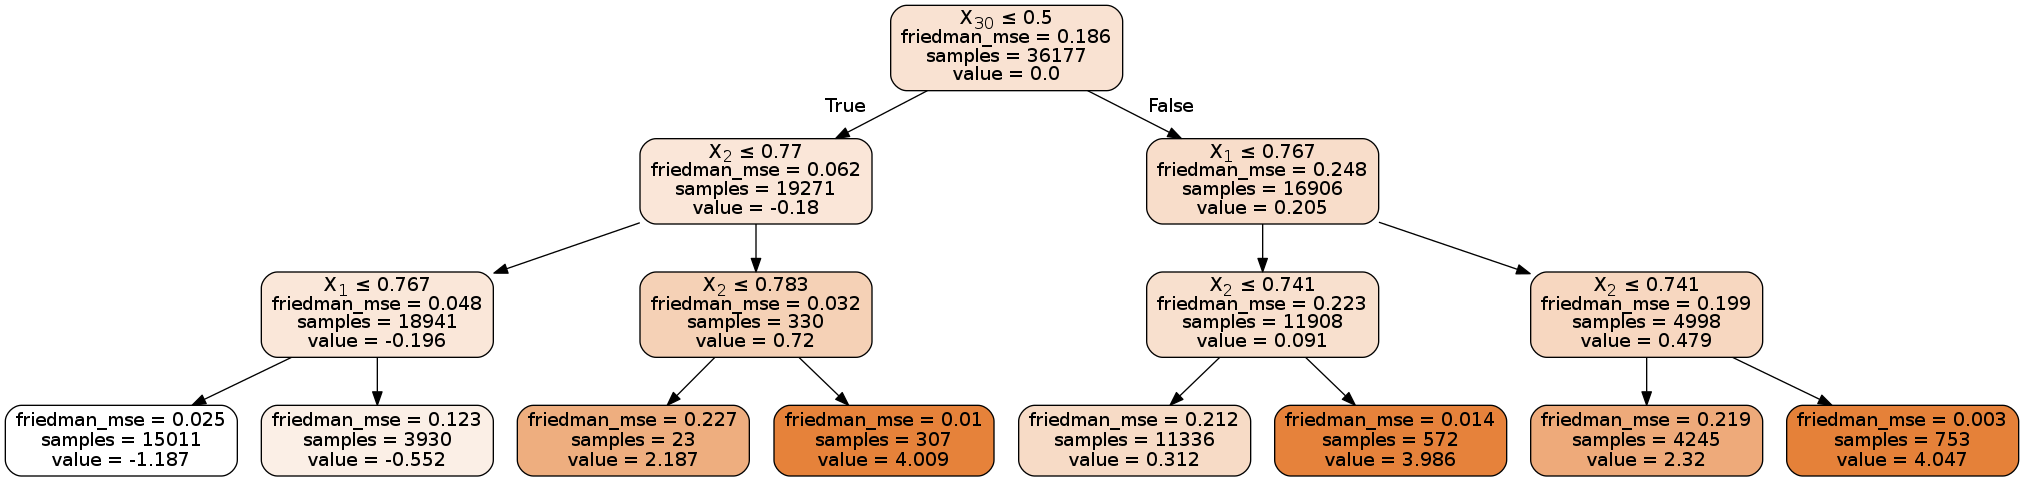

In [98]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

# Get one tree from the forest
tree_1=clf_C.estimators_[0][0]

# show me some Beauty
plot_tree=export_graphviz(
    tree_1,
    out_file=None,
    filled=True, 
    rounded=True,
    special_characters=True
)

show_tree=graph_from_dot_data(plot_tree)

Image(show_tree.create_png())

#### Note : Double click the image to zoom in 

###  Model Tuning
Improving the chosen model. Using  grid search (`GridSearchCV`) :

- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier we've chosen and store it in `clf`.
 - Set a `random_state` .
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features`  if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [24]:
#  Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
# Initialize the classifier
clf =  GradientBoostingClassifier(random_state=42)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = parameters = {
    'max_depth':[4],
    'min_samples_split':[ 25,30 ,35],
    "n_estimators":[250,300 ,350]
}

# Make an fbeta_score scoring object using make_scorer()
scorer =  make_scorer(fbeta_score , beta = 0.5)

#  Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit =  grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8638
F-score on testing data: 0.7580

Optimized Model
------
Final accuracy score on the testing data: 0.8743
Final F-score on the testing data: 0.7744


In [25]:
# Show the best model with its parameters
print(best_clf)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=30,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)


###  Final Model Evaluation

#### Results:

|     Metric     | Basline | Naive Pedictor  |  Unoptimized Model|Optimized Model  |
| :------------: | :-----: | :-------------: | :---------------: | :----------- -: | 
| Accuracy Score |   0.75  |    0.2478       |     0.8638        |    0.8743       |
|$F_{\beta}score$|   NAN   |    0.2917       |     0.7580        |    0.7744       |




- The optimized model's accuracy and $F_{\beta}score$ are 0.87 , 0.77 .

- As we can tell The optimized model has slightly better performance compared to the Unoptimized model.

- Comparing the naive predictor to The optimized model we can tell that, and Accuracy increased from 0.24 to 0.87 and $F_{\beta}score$ increased from 0.29 to 0.77.
- Also, The optimized model has higher Accuracy than the baseline of our data  0.87 > 0.75.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.


###  Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do we believe to be most important for prediction logically before we check it with our model, and in what order would we rank them and why?  

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


- **We can order them like followimg :**

    **1-Education-num**: Although there are no references for this column we can see that it is like an accumulative number that increases the higher the degree that the person has, it is a pure number and it will be much easier than the education level column for our model to compute. the higher the education level of the person the higher he makes at lest in most country  

    **2-age:**  older people tend to make more money .
    
    **3-marital-status**: As people with family have to support that mean more expensive , less saving.
    
    **4-occupation** : As some jobs make more than others. 
    
    **5-native-country** : As in some countries salary rates are higher.

###  Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

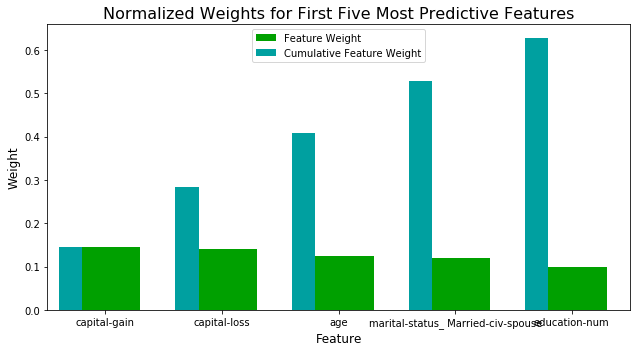

In [27]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train,y_train)
# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

###  Extracting Feature Importance



- According to the graph, we can see that we were right 3 out of 5, 

- On other hand: 
    - It turns out that  the capital gain and loss columns  ave more weight to estimate our target column. 
        
    - The marital-status column with a civilian married status has more weight to estimate our target column actually it is at the second one on importance level which is so interesting .

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [28]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8743
F-score on testing data: 0.7744

Final Model trained on reduced data
------
Accuracy on testing data: 0.8606
F-score on testing data: 0.7464


###  Effects of Feature Selection

- **As we can see  the results are slightly different in the Model trained on the reduced data but the difference was very small,therefore we can use the model trained on the reduced data as it will reduce the model training time and compute power.**


In [100]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 751331 bytes to finding_donors.html']